# 1. ASP Project: Designing an Auto-Wah for guitar

## 2. Abstract

boboob

## 3. Introduction

In [1]:
# Install libraries
! pip install scipy

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# General imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

# Audio imports
import scipy.signal as sgn
from scipy.io import wavfile

# Helpers
from helpers import *

### 3.1 The guitar sample we're working on

C:\Users\Me\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


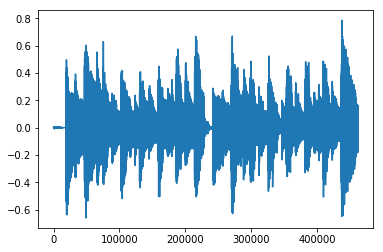

In [7]:
fs, data = wavfile.read('guitar.wav') # get data as integers
MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
data = data / MAX_VAL # now data is a normalized array of float between -1 and 1

plt.plot(data)
IPython.display.Audio(data, rate=fs)

## 4. Review of existing techniques (we tried)

We tried STFT, IIR time dependent filter...

## 5. Algorithm description

### 5.1 Compute the envelope of the signal (and set it to interesting freqs)

In [16]:
def compute_envelope (data, ma_width = 4000):
    envelope = np.concatenate((np.zeros(ma_width//2), data, np.zeros(ma_width//2)))
    envelope = moving_average(np.abs(envelope), ma_width)
    envelope_log = np.exp(envelope)
    envelope_log -= np.min(envelope_log)
    envelope_log /= np.max(envelope_log)
    envelopeF = envelope_log-np.percentile(envelope_log, 10)
    envelopeF /= np.percentile(envelope_log, 95)
    envelopeF = np.clip(envelopeF, 0, 1)
    envelopeF /= np.max(envelopeF)
    return envelopeF

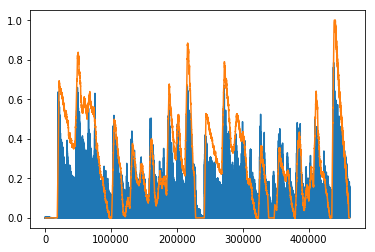

In [23]:
plt.plot(np.abs(data))
plt.plot(compute_envelope(data))
plt.show()

### 5.2 Auto-Wah using IIR Dynamic Filter

So we can see.

In [24]:
def autowah(data, maximum, minimum, order=2, peak= True, Q = 1, p=0.8, delay=0, fs = 44100):
    envelope = compute_envelope(data)
    Q = max(Q, 0.5)
    if peak and (p>1 or p < 0):
        raise ValueError("p must be between 0 and 1")
    y = np.zeros(len(data)+ order+1)
    z = np.zeros(len(data)+ order+1)# Create the y (order + 1 zeros at the begining to compute the 1st values...)
    if delay > 0 :
        d = np.concatenate((np.zeros(order+1+int(delay*fs)), data)) # add padded zeros at the beginning
    else:
        d = np.concatenate((np.zeros(order+1), data, np.zeros(int(-delay*fs)))) # add padded zeros at the beginning
    envelope = np.concatenate((np.zeros(order+1), envelope))

    vals_b = np.zeros(order+1)
    vals_a = np.zeros(order+1)

    for i in range(order+1, len(y)): # begin at order+1 since we must use previous values (0)

        if(i%100 == order+1): # sinon trop lent
            cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
            b, a = sgn.iirfilter(
                      N=order,
                      Wn=(cutoff),     
                      rp=30,
                      rs = 60,
                      btype='lowpass',
                      analog = False,
                      ftype='butter', 
                      output='ba')

        for j in range(0, order+1): # Compute X of the tranfer function
            vals_b[j] = b[j] * d[i-j]

        for j in range(1, order+1): # Compute Y of the tranfer function
            vals_a[j] = a[j] * y[i-j]

        y[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function
        
    if peak :
        for i in range(3, len(z)): # begin at order+1 since we must use previous values (0)

            if(i%100 == 3): # sinon trop lent
                cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
                b2, a2 = sgn.iirpeak(cutoff, Q)

            for j in range(0, 3): # Compute X of the tranfer function
                vals_b[j] = b2[j] * y[i-j]

            for j in range(1, 3): # Compute Y of the tranfer function
                vals_a[j] = a2[j] * z[i-j]

            z[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function
    y = p*z+(1-p)*y
    return y/np.max(abs(y))

## 6. Results and discussion

In [21]:
def renderAutowah (file, maximum = 2000, minimum = 401, peak = True, p = 1, write=False, output = "output.wav"):
    fs, data = wavfile.read(file) # get data as integers
    MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
    data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
    
    y = autowah(data, maximum, minimum, peak = True, Q = 0.8, p = 1, delay = 0)
    y = np.asarray(y, dtype=np.float32)
    if write :
        wavfile.write(output, fs, y)
    return y, fs

C:\Users\Me\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


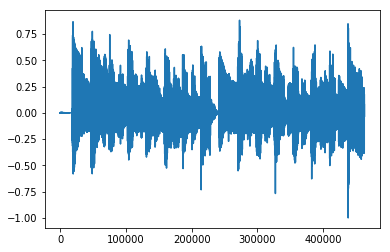

In [22]:
y, fs = renderAutowah("guitar.wav", maximum = 2000, minimum = 401, peak = True, p = 1)
y = np.asarray(y, dtype=np.float32)
plt.plot(y)
plt.show()
IPython.display.Audio(y, rate=fs)

## 7. Conclusion

## 8. Bibliography